[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)

#### based on Fig. 2 from Gedzelman and Arnold 1994 (JGR)  "_Modeling the isotopic composition of precipitation_"
https://doi.org/10.1029/93JD03518

- extended to cover also Oxygen-18 (in addition to Deuterium)

In [22]:
# TODO #1307 - ventilation coeff
# TODO #1307 - find out why the plots do not match
# TODO #1307 - smoke test
# TODO #1307 - move new formulae into physics 
# TODO #1307 - text labels on the plot
# TODO #1307 - include derivation in notebook header
# TODO #1307 - contour plot of dR/dt (from formulae) with zero isolina matching the paper fig?

In [23]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM')

In [76]:
from open_atmos_jupyter_utils import show_plot
from PySDM import Formulae
from PySDM.physics.constants import si, PER_MILLE, T0
from matplotlib import pyplot
import numpy as np

In [77]:
formulae = Formulae(isotope_equilibrium_fractionation_factors='HoritaAndWesolowski1994')
const = formulae.constants

In [98]:
class AmbientAir:
    def __init__(self, *, isotope, delta_v, temperature):
        self.vsmow_ratio = getattr(const, f'VSMOW_R_{isotope}')
        self.iso_ratio_v = formulae.trivia.isotopic_delta_2_ratio(delta_v, self.vsmow_ratio)
        self.b = formulae.latent_heat.lv(temperature)**2 * const.D0 / const.K0 / const.Rv / temperature**2
        self.alpha_w = getattr(
            formulae.isotope_equilibrium_fractionation_factors,
            f'alpha_l_{isotope}'
        )(temperature)

        self.diff_coef_ratio = getattr(const, f'D_light_H2O__over__D_{isotope}_enriched')        
        self.vent_coeff_ratio = 1 # TODO #1307
        
class NoFractionationSaturation:
    def __init__(self, *, ambient_air: AmbientAir, liquid: bool = False, vapour: bool = False):
        assert liquid != vapour
        self.liquid = liquid
        self.ambient_air = ambient_air
        
    def __call__(self, iso_ratio_r):
        iso_ratio_x = iso_ratio_r if self.liquid else self.ambient_air.iso_ratio_v
        diff_rat = self.ambient_air.vent_coeff_ratio * self.ambient_air.diff_coef_ratio
        return (
            diff_rat * iso_ratio_x 
            - iso_ratio_r / self.ambient_air.alpha_w
        ) / (
            diff_rat * iso_ratio_x 
            - (1 + self.ambient_air.b) * self.ambient_air.iso_ratio_v
            + self.ambient_air.b * iso_ratio_r / self.ambient_air.alpha_w
        )

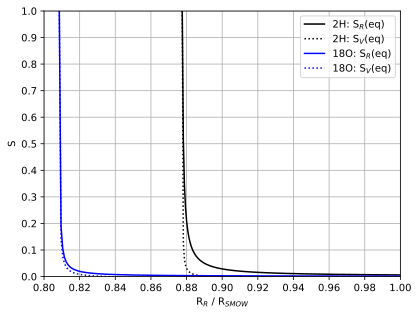

HTML(value="<a href='./fig_2.pdf' target='_blank'>./fig_2.pdf</a><br>")

In [119]:
for iso, color in {'2H': 'black', '18O': 'blue'}.items():
    ambient_air = AmbientAir(
        isotope=iso,
        delta_v= -200 * PER_MILLE,
        temperature= T0 + 10 * si.K
    )
    eq_22 = NoFractionationSaturation(ambient_air=ambient_air, liquid=True)
    eq_23 = NoFractionationSaturation(ambient_air=ambient_air, vapour=True)
    
    x = np.linspace(ambient_air.alpha_w * ambient_air.iso_ratio_v / ambient_air.vsmow_ratio, 1, 200)
    pyplot.plot(x, eq_22(x * ambient_air.vsmow_ratio), label=f'{iso}: S$_R$(eq)', color=color)
    pyplot.plot(x, eq_23(x * ambient_air.vsmow_ratio), label=f'{iso}: S$_V$(eq)', color=color, linestyle=':')
    
    pyplot.xlim(.8, 1)
    pyplot.xticks(np.linspace(.8, 1, 11))
    pyplot.xlabel('R$_R$ / R$_{SMOW}$')
    
    pyplot.ylim(0, 1)
    pyplot.yticks(np.linspace(0, 1, 11))
    pyplot.ylabel('S')

    pyplot.grid(visible=True, axis='both')
    pyplot.legend()

show_plot('fig_2.pdf')